In [1]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [18]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27
textheight = 657.3189 / 72.27

mpl.rcParams.update({'font.size': 8})

In [3]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

In [4]:
Rs_list = ['116', '129', '142']
Vv_list = ['116', '129', '142']
eta_list = ['04', '05', '06']

sims = []
for Rs in Rs_list:
    for Vv in Vv_list:
        for eta in eta_list:
            sims.append((Rs, Vv, eta))

In [5]:
def load_galaxy(sim, idx=320):
    Rs, Vv, eta = sim
    key = 'lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+eta
    return galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              idx, orient=True)

In [9]:
gal = {}
for sim in tqdm(sims):
    gal[sim] = load_galaxy(sim)

100%|██████████| 27/27 [01:24<00:00,  3.12s/it]


In [26]:
def extract_sim_data(gal):
    sn = gal.sn
    
    ### get logFeH and logMgFe ###
    FeH = sn.part4.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = sn.part4.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH

    ### get in_SN ###
    Lzsun = 8 * 220 * 0.2
    zmax = 3
    dLz = 0.3
    
    Lz = np.cross(sn.part4.rotpos, sn.part4.rotvel)[:,2]
    in_SN = np.logical_and(np.abs((Lz/Lzsun)-1) < dLz, np.abs(sn.part4.rotpos[:,2]) < zmax)
    
    ### get tform ###
    tform = sn.part4.GFM_StellarFormationTime
    keybool = np.logical_and(in_SN, tform > 0)
    
    out = {}
    out['logFeH'] = logFeH[in_SN]
    out['logMgFe'] = logMgFe[in_SN]
    out['tform'] = tform[in_SN]
    out['birthmass'] = sn.part4.GFM_InitialMass[in_SN]
    
    return out

In [27]:
simdata = {}
for sim in tqdm(sims):
    simdata[sim] = extract_sim_data(gal[sim])

100%|██████████| 27/27 [00:00<00:00, 48.10it/s]


In [72]:
N_FeH = 125
N_MgFe = 125

def plot_panel(sim, fig, axs, logFeH_lim, logMgFe_lim, logFeH0_list, 
               offset=-0.3, doffset = 0.3, poffset=0.1, vmax=4e5):
    data = simdata[sim]
    ax0 = axs[0]
    ax1 = axs[1]
    ax2 = axs[2]
    
    logFeH = data['logFeH']
    logMgFe = data['logMgFe']
    tform = data['tform']
    birthmass = data['birthmass']
    
    FeH_bins  = np.linspace(logFeH_lim[0],  logFeH_lim[1],  N_FeH+1)
    MgFe_bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], N_MgFe+1)
    dFeH  = (logFeH_lim[1]  - logFeH_lim[0] )/N_FeH
    dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe
    H, _, _, _ = binned_statistic_2d(logFeH, logMgFe, 
                                     np.ones(len(logFeH))/dFeH/dMgFe,
                                     statistic='sum', bins=[FeH_bins, MgFe_bins])
    
    im = ax0.imshow(H.T, origin='lower', extent=[logFeH_lim[0],  logFeH_lim[1],
                                                    logMgFe_lim[0], logMgFe_lim[1]],
                       cmap='Greys', vmin=0, vmax=vmax)
    
    ax0.set(xlim=logFeH_lim, ylim=logMgFe_lim)
    ax0.set(xlabel=r'$[\textrm{Fe}/\textrm{H}]$', ylabel=r'$[\textrm{Mg}/\textrm{Fe}]$')
    ax0.set(aspect='auto')
    
    m = -0.15/1.5
    b = 0.31
    xlist = np.linspace(-3, 3, 1000)
    ylist = m*xlist + b
    ax0.plot(xlist, ylist, c='r', ls='dashed', lw=0.5)
    
    dlogFeH0 = 0.05
    d = 0.25/2
    offset_list = [d, 0.25+d, 0.5+d, 0.75+d]
    
    tbins =np.linspace(0, 8, 100+1)
    dt = (tbins[-1] - tbins[0]) / (len(tbins)-1)
    wt = birthmass/dt/dlogFeH0
    tplot = 0.5*(tbins[1:] + tbins[:-1])
    
    for i,(logFeH0, c) in enumerate(zip(logFeH0_list, [tb_c[0], tb_c[1], tb_c[2], tb_c[4]])):
        offset = offset_list[i]
        key = np.logical_and(logFeH > logFeH0 - dlogFeH0/2., logFeH < logFeH0 + dlogFeH0/2.)
    
        _, _, l = ax1.hist(logMgFe[key]-np.median(logMgFe[key])+offset, 
                              bins=np.linspace(-d/2, 1+d/2, 100+1),
                              density=True, histtype='step', color=c, lw=1)

        ax0.axvline(logFeH0, c=l[0].get_edgecolor())
        
        # if i < 3:
        if True:
            hist, _ = np.histogram(tform[key], weights=wt[key], bins=tbins)
            ax2.plot(tplot, hist, c=c, lw=1)
        
        offset += doffset
    
    # hist, _ = np.histogram(tform, weights=wt, bins=tbins)
    # ax2.plot(tplot, hist/5, c='k', lw=0.8)
    
    ax1.set(ylim=(0, 20), xlim=(-d/2, 1+d/2))
    
    # ax0.set(xticks=np.arange(-1, 0.5+0.25, 0.25))
    ax1.set(xlabel=r'$[\textrm{Mg}/\textrm{Fe}] + \textrm{ offset}$')
    
    ax2.set(xlim=(0, 8), ylim=(0, 0.5))
    ax2.set(xlabel=r'$t_{\textrm{form}}\,[\,\textrm{Gyr}\,]$')
    ax2.set(xticks=np.arange(0, 8+1, 1))
    
    ax0.set_title(r'$('+str(sim[0])+', '+str(sim[1])+', '+str(sim[2])+')$')

In [73]:
logFeH0_list=[-0.5, -0.25, 0, 0.25]

for i in tqdm(range(9)):
    fig, axs = plt.subplots(3, 3, figsize=(textwidth, 0.5*textheight))
    
    for j in range(3):
        plot_panel(sims[i*3+j], fig, (axs[0][j], axs[1][j], axs[2][j]), 
                   (-1, 0.5), (0.1, 0.65), logFeH0_list)

    fig.tight_layout()
    fig.savefig('allmerge'+str(i)+'.pdf')
    plt.close()

100%|██████████| 9/9 [00:16<00:00,  1.80s/it]


In [40]:
pwd

'/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/plots/allmerge'

In [41]:
tform = simdata[sims[0]]['tform']

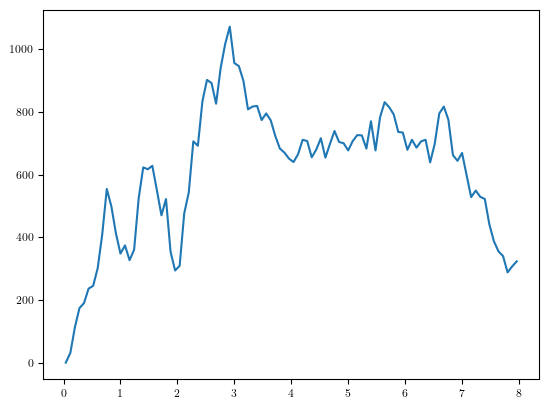

In [50]:
tbins = np.linspace(0, 8, 100+1)
tplot = 0.5*(tbins[1:] + tbins[:-1])
hist, _ = np.histogram(tform, bins=tbins)
plt.plot(tplot, hist)

In [49]:
8/100

0.08